TP Groupe - Noé Duhamel, Guillaume Gatille & Nathan Stoos

In [65]:
import os
import re
from collections import Counter, defaultdict
from pprint import pprint
import string

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.cluster import KMeans

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel


bible_cleaned_filename = 'bible-cleaned.csv'

In [66]:
df_path = "bible.csv"
df = pd.read_csv(df_path)
print("Rows: " + format(df.shape[0]))
print("Colulmns: " + format(df.shape[1]))

Rows: 31103
Colulmns: 5


In [67]:
df.head()

,id,b,c,v,t
0,1001001,1,1,1,In the beginning God created the heaven and th...
1,1001002,1,1,2,"And the earth was without form, and void; and ..."
2,1001003,1,1,3,"And God said, Let there be light: and there wa..."
3,1001004,1,1,4,"And God saw the light, that it was good: and G..."
4,1001005,1,1,5,"And God called the light Day, and the darkness..."


Let's define the variable which will split the data set in New and Old Testament.

In [68]:
df['t'] = df['t'].astype('str')
df.loc[df['b'] <= 39, 'testament'] = 'Old'
df.loc[df['b'] > 39, 'testament'] = 'New'
df

,id,b,c,v,t,testament
0,1001001,1,1,1,In the beginning God created the heaven and th...,Old
1,1001002,1,1,2,"And the earth was without form, and void; and ...",Old
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",Old
3,1001004,1,1,4,"And God saw the light, that it was good: and G...",Old
4,1001005,1,1,5,"And God called the light Day, and the darkness...",Old
...,...,...,...,...,...,...
31098,66022017,66,22,17,"And the Spirit and the bride say, Come. And le...",New
31099,66022018,66,22,18,For I testify unto every man that heareth the ...,New
31100,66022019,66,22,19,And if any man shall take away from the words ...,New
31101,66022020,66,22,20,"He which testifieth these things saith, Surely...",New


In [69]:
# Stats descriptives sur le dataframe
df.rename(columns={
    'b': 'book_id', 
    'c': 'chapter_id',
    'v': 'verse_id',
    't': 'text'
    }, inplace=True)

df

,id,book_id,chapter_id,verse_id,text,testament
0,1001001,1,1,1,In the beginning God created the heaven and th...,Old
1,1001002,1,1,2,"And the earth was without form, and void; and ...",Old
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",Old
3,1001004,1,1,4,"And God saw the light, that it was good: and G...",Old
4,1001005,1,1,5,"And God called the light Day, and the darkness...",Old
...,...,...,...,...,...,...
31098,66022017,66,22,17,"And the Spirit and the bride say, Come. And le...",New
31099,66022018,66,22,18,For I testify unto every man that heareth the ...,New
31100,66022019,66,22,19,And if any man shall take away from the words ...,New
31101,66022020,66,22,20,"He which testifieth these things saith, Surely...",New


In [70]:
# Get the list of stopwords to delete 
words_to_delete = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
                   "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
                   'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
                   'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 
                   'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
                   'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 
                   'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 
                   'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
                   'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
                   'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 
                   'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 
                   'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', 
                   "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
                   'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
                    , 'unto', 'thou', 'thee', 'ye', 'him', 'upon', 'say', 'me', 'hath', 'also',"shouldn't", "wasn't", "weren't", 
                    "won't", "wouldn't", "unto", "thou", "thee", "ye", "him", "upon", "say", "me", "hath", "also", "ye"
                  ]

In [71]:
if os.path.isfile(bible_cleaned_filename):
    bible_df = pd.read_csv(bible_cleaned_filename, index_col=0)
else:
    # Remove the specified words from the text
    df['text_cleaned'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in words_to_delete]))

    # Remove numbers
    df['text_cleaned'] = df['text_cleaned'].str.replace(r'\d+', '')

    # Remove punctuation
    df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

    # Remove extra whitespaces
    df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

    # Convert text_cleaned to lowercase
    df['text_cleaned'] = df['text_cleaned'].str.lower()

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    df['text_cleaned'] = df['text_cleaned'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    
    df.to_csv(bible_cleaned_filename)

In [72]:
df.head()

,id,book_id,chapter_id,verse_id,text,testament,text_cleaned
0,1001001,1,1,1,In the beginning God created the heaven and th...,Old,beginning god created heaven earth
1,1001002,1,1,2,"And the earth was without form, and void; and ...",Old,earth without form void darkness face deep spi...
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",Old,god said let light light
3,1001004,1,1,4,"And God saw the light, that it was good: and G...",Old,god saw light good god divided light darkness
4,1001005,1,1,5,"And God called the light Day, and the darkness...",Old,god called light day darkness called night eve...


In [73]:
# Test cleaning efficiency printing the first row
# cela permet de comparer les différentes étapes de nettoyage
print('Cleaned text: \n' + str(df['text'][0]))
print('Cleaned text: \n' + str(df['text_cleaned'][0]))

Cleaned text: 
In the beginning God created the heaven and the earth.
Cleaned text: 
beginning god created heaven earth


# Data Analysis

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31103 entries, 0 to 31102
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            31103 non-null  int64 
 1   book_id       31103 non-null  int64 
 2   chapter_id    31103 non-null  int64 
 3   verse_id      31103 non-null  int64 
 4   text          31103 non-null  object
 5   testament     31103 non-null  object
 6   text_cleaned  31103 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.7+ MB


In [75]:
columns_to_convert = ['id', 'book_id', 'chapter_id', 'verse_id']
df[columns_to_convert] = df[columns_to_convert].astype('int16')
print(df.dtypes)

id               int16
book_id          int16
chapter_id       int16
verse_id         int16
text            object
testament       object
text_cleaned    object
dtype: object


In [76]:
columns_to_convert = ['text', 'testament', 'text_cleaned']
df[columns_to_convert] = df[columns_to_convert].astype('string')
print(df.dtypes)


id                       int16
book_id                  int16
chapter_id               int16
verse_id                 int16
text            string[python]
testament       string[python]
text_cleaned    string[python]
dtype: object


In [77]:
# Add descriptive columns
df['word_count'] = df['text_cleaned'].apply(lambda x: len(x.split()))
df['unique_word_count'] = df['text_cleaned'].apply(lambda x: len(set(x.split())))
df['sentence_count'] = df['text_cleaned'].apply(lambda x: len(sent_tokenize(x)))
df['avg_word_length'] = df['text_cleaned'].apply(lambda x: np.mean([len(word) for word in x.split()])).round(2)
df

c:\Users\guill\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,id,book_id,chapter_id,verse_id,text,testament,text_cleaned,word_count,unique_word_count,sentence_count,avg_word_length
0,17961,1,1,1,In the beginning God created the heaven and th...,Old,beginning god created heaven earth,5,5,1,6.00
1,17962,1,1,2,"And the earth was without form, and void; and ...",Old,earth without form void darkness face deep spi...,12,11,1,4.92
2,17963,1,1,3,"And God said, Let there be light: and there wa...",Old,god said let light light,5,4,1,4.00
3,17964,1,1,4,"And God saw the light, that it was good: and G...",Old,god saw light good god divided light darkness,8,6,1,4.75
4,17965,1,1,5,"And God called the light Day, and the darkness...",Old,god called light day darkness called night eve...,11,9,1,5.27
...,...,...,...,...,...,...,...,...,...,...,...
31098,27265,66,22,17,"And the Spirit and the bride say, Come. And le...",New,spirit bride say come let heareth say come let...,18,13,1,4.67
31099,27266,66,22,18,For I testify unto every man that heareth the ...,New,testify every man heareth word prophecy book m...,17,13,1,4.82
31100,27267,66,22,19,And if any man shall take away from the words ...,New,man shall take away word book prophecy god sha...,19,14,1,4.42
31101,27268,66,22,20,"He which testifieth these things saith, Surely...",New,testifieth thing saith surely come quickly ame...,12,11,1,5.00


Avec cet ensemble de données donné, on peux appliquer une analyse complète. Tout d'abord, on commence par un sujet intéressant : comment la longueur des versets évolue à travers les livres de la Bible. 
Pourquoi cette information peut-elle être utile ? Elle nous permet d'estimer approximativement quand les livres ont été écritset la longueur des versets  offre beaucoup de connaissances sur la culture a ce moment.

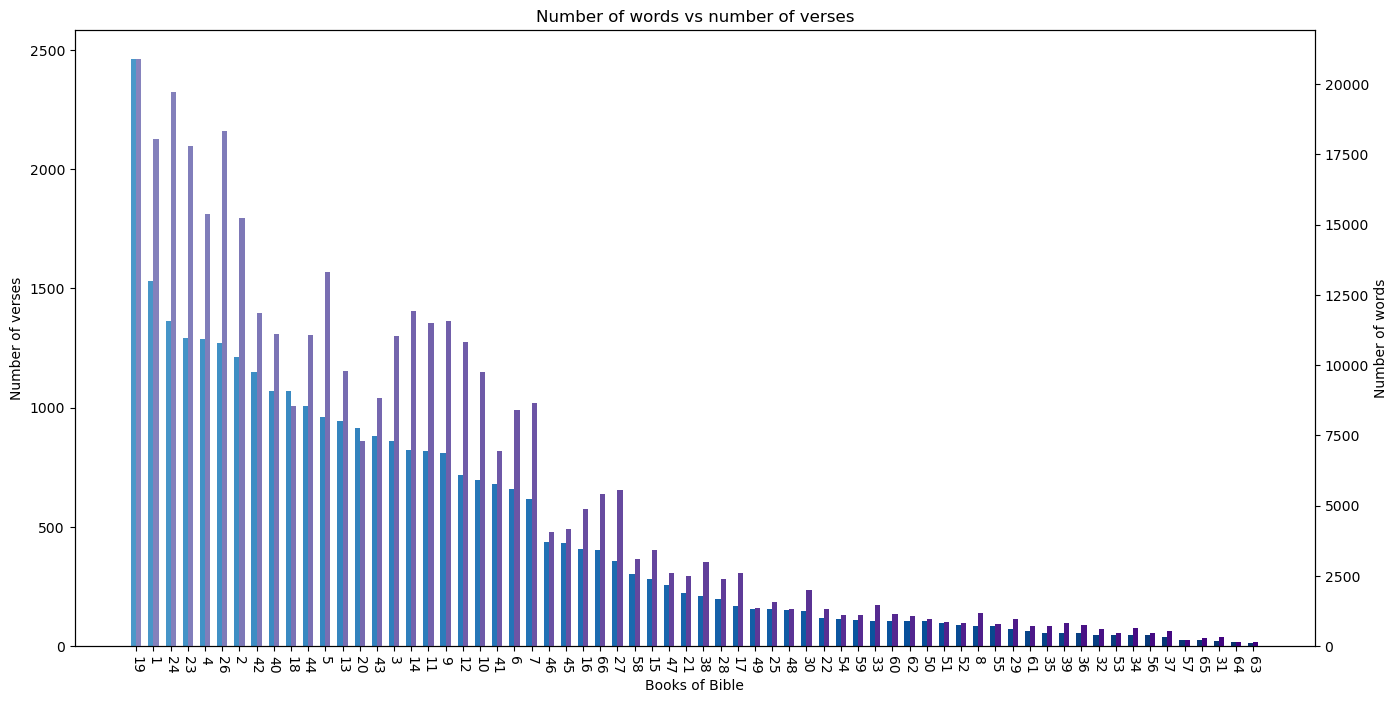

In [78]:
# Assuming 'verse_id' represents the number of verses and 'word_count' represents the number of words
# Change these column names based on your actual DataFrame columns
verses_column = 'verse_id'
words_column = 'word_count'

# Generate color maps
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

# Group by 'book_id' instead of 'Book', assuming 'book_id' represents the books of the Bible
words_verses = df.groupby('book_id').agg({verses_column: 'count', words_column: 'sum'}).sort_values(by=verses_column, ascending=False)
data1 = words_verses[verses_column]
data2 = words_verses[words_column]

plt.figure(figsize=(16, 8))
x = np.arange(66)
ax1 = plt.subplot(1, 1, 1)
w = 0.3

color = color_1
plt.title('Number of words vs number of verses')
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel('Books of Bible')
ax1.set_ylabel('Number of verses')
ax1.bar(x, data1.values, color=color_1, width=w, align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Number of words')
ax2.bar(x + w, data2, color=color_2, width=w, align='center')

plt.show()


En visualisant l'évolution du nombre total de mots par livre, on peux  obtenir des informations sur la longueur relative des livres. Certains livres peuvent être plus longs que d'autres, ce qui peut refléter la complexité de leur contenu.

In [96]:
# # Calcul du nombre total de mots par livre
# total_words_by_book = df.groupby('book_id')['word_count'].sum().reset_index()

# # Plotting
# plt.figure(figsize=(15, 6))
# sns.lineplot(x='book_id', y='word_count', data=total_words_by_book, marker='o', color='green')
# plt.title('Evolution of the Number of Words in Books')
# plt.xlabel('Book ID')
# plt.ylabel('Total Word Count')
# plt.show()

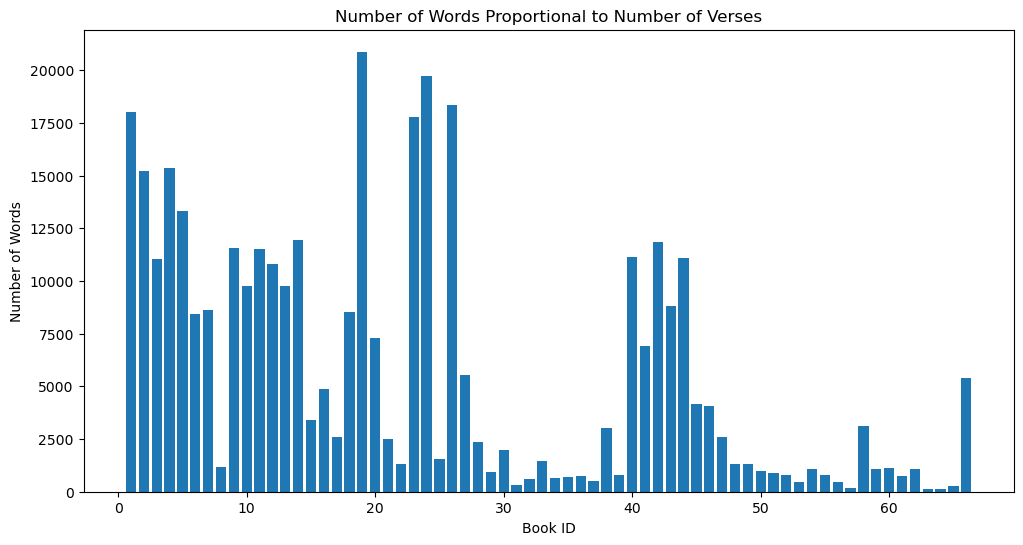

In [95]:
# Group the dataframe by book_id and calculate the sum of occurrences for each word
verses_counts = df.groupby('book_id')['verse_id'].count()
words_counts = df.groupby('book_id')['word_count'].sum()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(verses_counts.index, words_counts, width=0.8)
plt.xlabel('Book ID')
plt.ylabel('Number of Words')
plt.title('Number of Words per Books')
plt.show()

En analysant graphiquement les données, on peut rapidement identifier les livres où les références à "God" et "Jesus" sont plus fréquentes, ainsi que les tendances générales au fil des différents IDs de livre. Ici Jésus apparait dans le New testament logiquement.

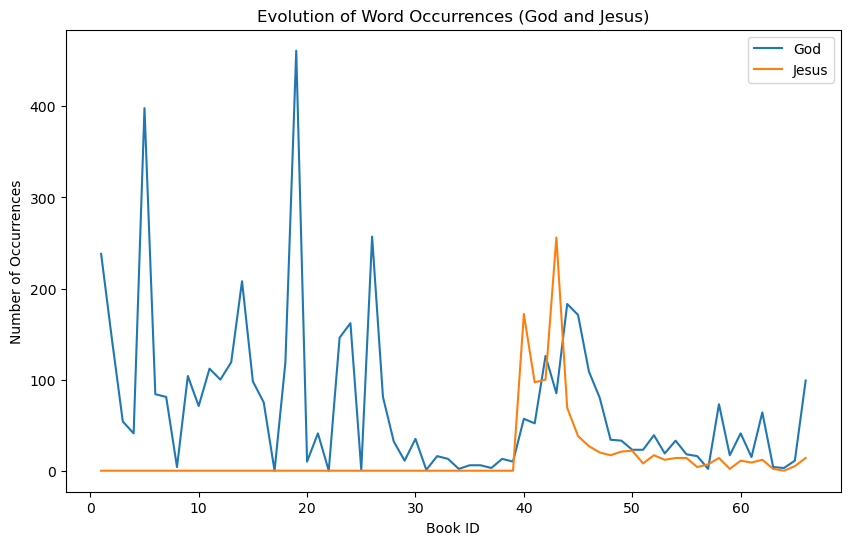

In [80]:
# Group the dataframe by book_id and calculate the sum of occurrences for each word
god_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('god').sum())
jesus_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('jesus').sum())

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(god_counts.index, god_counts.values, label='God')
plt.plot(jesus_counts.index, jesus_counts.values, label='Jesus')
plt.xlabel('Book ID')
plt.ylabel('Number of Occurrences')
plt.title('Evolution of Word Occurrences (God and Jesus)')
plt.legend()
plt.show()

Ce graphique facilite  l'identification de tendances générales dans l'utilisation de ces termes clés lié au pouvoir et facilitant ainsi une analyse thématique eventuel.

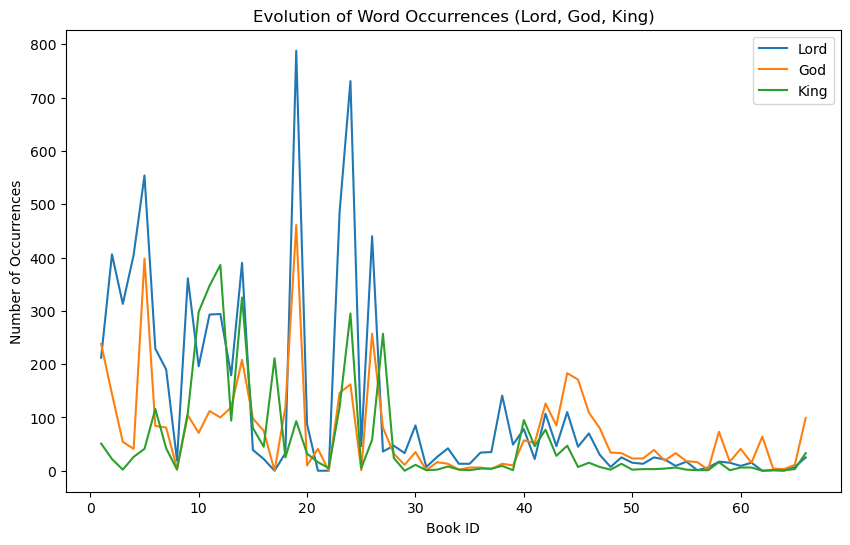

In [81]:
# Group the dataframe by book_id and calculate the sum of occurrences for each word
lord_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('lord').sum())
god_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('god').sum())
king_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('king').sum())

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(lord_counts.index, lord_counts.values, label='Lord')
plt.plot(god_counts.index, god_counts.values, label='God')
plt.plot(king_counts.index, king_counts.values, label='King')
plt.xlabel('Book ID')
plt.ylabel('Number of Occurrences')
plt.title('Evolution of Word Occurrences (Lord, God, King)')
plt.legend()
plt.show()


La représentation graphique des termes "Holy," "Son," et "Father" dans l'Ancien Testament et le NOUVEAU est utile car elle offre une vision  des thèmes théologiques ET permet une compréhension  rapide du vocabulaire utilisé.

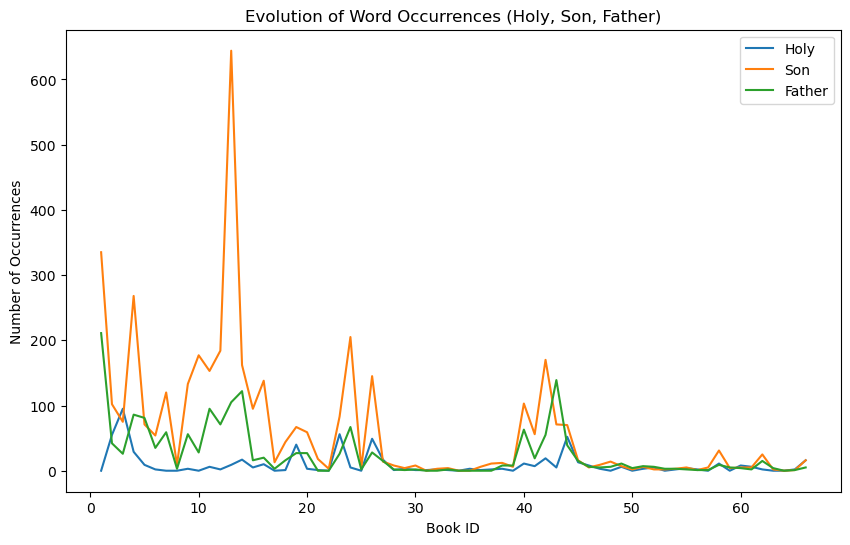

In [82]:
import matplotlib.pyplot as plt
# Group the dataframe by book_id and calculate the sum of occurrences for each word
holy_spirit_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('holy').sum())
son_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('son').sum())
father_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('father').sum())

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(holy_spirit_counts.index, holy_spirit_counts.values, label='Holy')
plt.plot(son_counts.index, son_counts.values, label='Son')
plt.plot(father_counts.index, father_counts.values, label='Father')
plt.xlabel('Book ID')
plt.ylabel('Number of Occurrences')
plt.title('Evolution of Word Occurrences (Holy, Son, Father)')
plt.legend()
plt.show()


Visulation en nuage de mots de ceux les plus utilisés entre ancien et nouveau testament

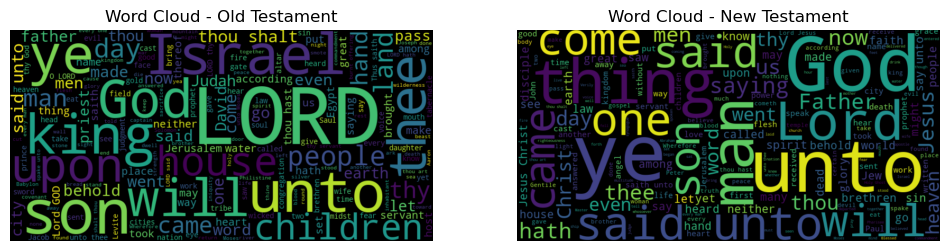

In [83]:
# Filter the dataframe to get the text from the Old Testament
old_testament_text = ' '.join(df[df['testament'] == 'Old']['text'])

# Generate a word cloud for the Old Testament
wordcloud_old = WordCloud(width=800, height=400, max_font_size=150).generate(old_testament_text)

# Filter the dataframe to get the text from the New Testament
new_testament_text = ' '.join(df[df['testament'] == 'New']['text'])

# Generate a word cloud for the New Testament
wordcloud_new = WordCloud(width=800, height=400, max_font_size=150).generate(new_testament_text)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_old, interpolation='bilinear')
plt.title('Word Cloud - Old Testament')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_new, interpolation='bilinear')
plt.title('Word Cloud - New Testament')
plt.axis('off')

plt.show()



## N-gramm / Bi-gramm

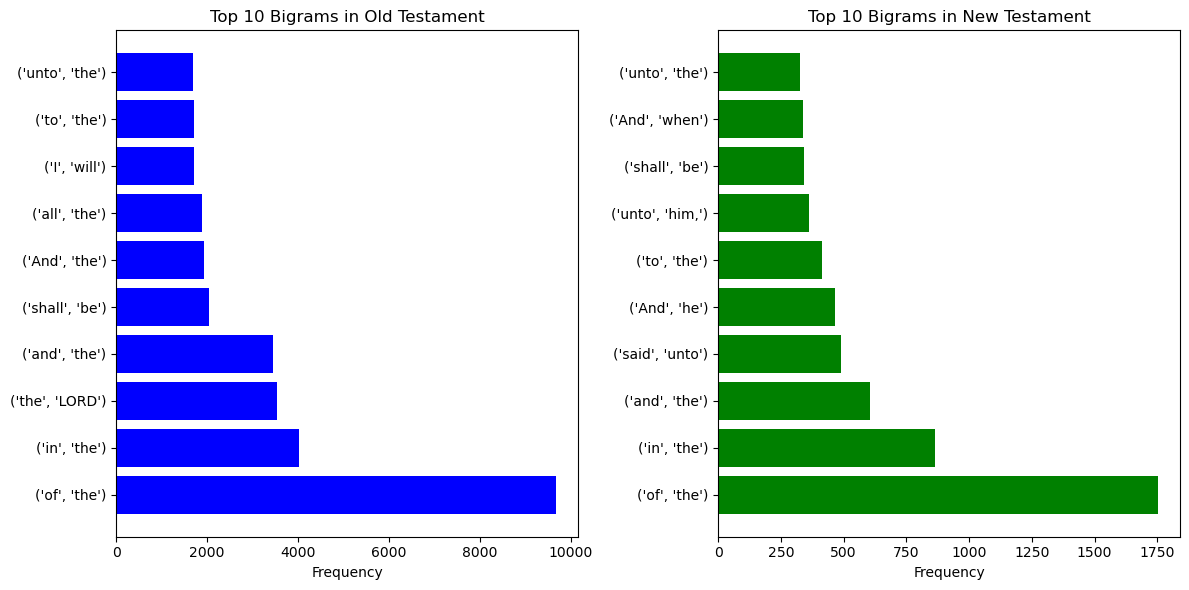

In [84]:
# Function to get the most frequent n-grams
def get_most_frequent_ngrams(text, n, top_k):
    # Tokenize the text into words
    words = text.split()
    
    # Generate the n-grams
    ngrams_list = list(ngrams(words, n))
    
    # Count the frequency of each n-gram
    ngrams_freq = Counter(ngrams_list)
    
    # Get the top k most frequent n-grams
    top_ngrams = ngrams_freq.most_common(top_k)
    
    return top_ngrams

# Get the most frequent bigrams in the Old Testament
old_testament_bigrams = get_most_frequent_ngrams(old_testament_text, 2, 10)

# Get the most frequent bigrams in the New Testament
new_testament_bigrams = get_most_frequent_ngrams(new_testament_text, 2, 10)

# Plot bar graphs for Old and New Testament bigrams
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Old Testament Bigrams
axes[0].barh([str(bigram) for bigram, frequency in old_testament_bigrams], [frequency for bigram, frequency in old_testament_bigrams], color='blue')
axes[0].set_title('Top 10 Bigrams in Old Testament')
axes[0].set_xlabel('Frequency')

# New Testament Bigrams
axes[1].barh([str(bigram) for bigram, frequency in new_testament_bigrams], [frequency for bigram, frequency in new_testament_bigrams], color='green')
axes[1].set_title('Top 10 Bigrams in New Testament')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()


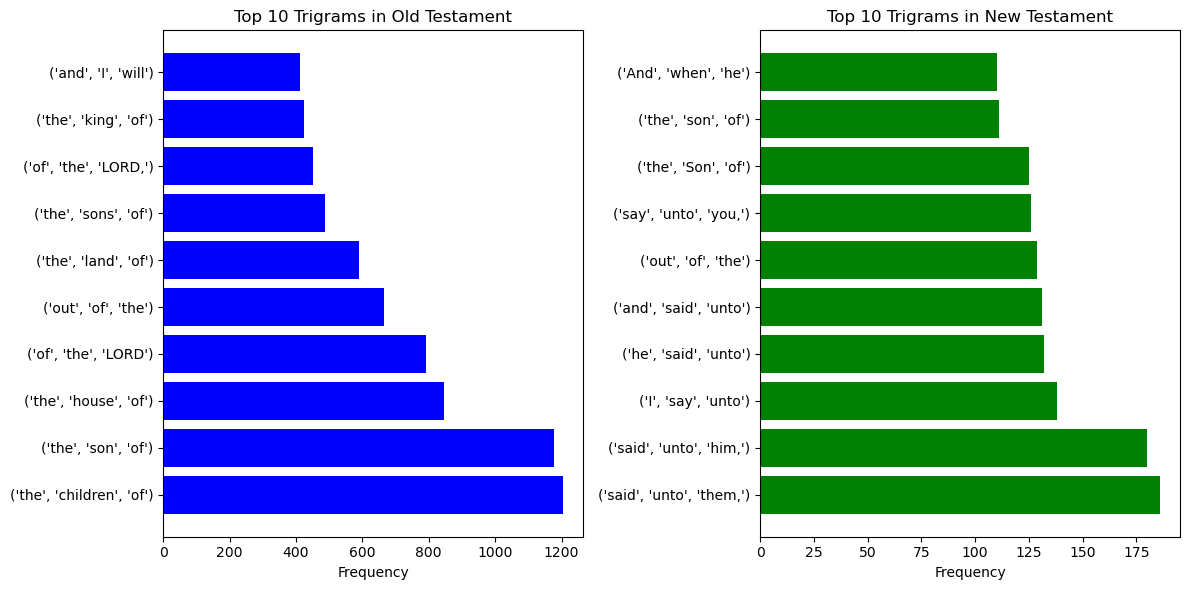

In [85]:
# Function to get the most frequent n-grams
def get_most_frequent_ngrams(text, n, top_k):
    # Tokenize the text into words
    words = text.split()
    
    # Generate the n-grams
    ngrams_list = list(ngrams(words, n))
    
    # Count the frequency of each n-gram
    ngrams_freq = Counter(ngrams_list)
    
    # Get the top k most frequent n-grams
    top_ngrams = ngrams_freq.most_common(top_k)
    
    return top_ngrams

# Get the most frequent trigrams in the Old Testament
old_testament_trigrams = get_most_frequent_ngrams(old_testament_text, 3, 10)

# Get the most frequent trigrams in the New Testament
new_testament_trigrams = get_most_frequent_ngrams(new_testament_text, 3, 10)

# Sort trigrams by frequency in descending order
old_testament_trigrams.sort(key=lambda x: x[1], reverse=True)
new_testament_trigrams.sort(key=lambda x: x[1], reverse=True)

# Plot bar graphs for Old and New Testament trigrams
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Old Testament Trigrams
axes[0].barh([str(trigram) for trigram, frequency in old_testament_trigrams], [frequency for trigram, frequency in old_testament_trigrams], color='blue')
axes[0].set_title('Top 10 Trigrams in Old Testament')
axes[0].set_xlabel('Frequency')

# New Testament Trigrams
axes[1].barh([str(trigram) for trigram, frequency in new_testament_trigrams], [frequency for trigram, frequency in new_testament_trigrams], color='green')
axes[1].set_title('Top 10 Trigrams in New Testament')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()


## BOW - Corpus

In [86]:
# Utilisez CountVectorizer pour obtenir les caractéristiques du sac de mots
cv = CountVectorizer()
cv_matrix = cv.fit_transform(df['text_cleaned'])

# Obtenez tous les mots uniques dans le corpus
vocab = cv.get_feature_names_out()

# Affichez les vecteurs de caractéristiques des documents dans un DataFrame
bible_df_feature_vectors = pd.DataFrame(cv_matrix.toarray(), columns=vocab)

# Affichez le DataFrame
bible_df_feature_vectors

,aaron,aaronites,abaddon,abagtha,abana,abarim,abase,abased,abasing,abated,...,zorathites,zoreah,zorites,zorobabel,zuar,zuph,zur,zuriel,zurishaddai,zuzims
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

In [87]:
# Aggrégation des versets par livre pour effecter une analyse par livre

books = {}
for verse in range(len(df)):
    current_book = df['book_id'].iloc[verse]
    if(current_book in books):
        books[current_book] = str(books[current_book]) + str(df['text_cleaned'].iloc[verse]) + ' '
    else: 
        books[current_book] = str(df['text_cleaned'].iloc[verse]) + ' '

books_list = list(books.values())
books_df = pd.DataFrame(books_list, columns=['corpus'])

del books_list

In [88]:
# Créez un objet TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Ajustez le TfidfVectorizer sur la colonne 'text_cleaned' des livres échantillonnés
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['corpus'])

# Obtenez les noms de fonctionnalités (vocabulaire)
vocab = tfidf_vectorizer.get_feature_names_out()

# Créez une liste pour stocker les 3 principaux termes TF-IDF pour chaque livre
top_tfidf_terms_list = []

# Itérez sur chaque livre échantillonné et obtenez les 3 principaux termes TF-IDF
for idx, book in enumerate(books_df['corpus']):
    tfidf_scores = tfidf_matrix[idx, :].toarray().flatten()
    
    # Créez un dictionnaire pour stocker le terme et son score TF-IDF
    tfidf_dict = {term: round(score, 2) for term, score in zip(vocab, tfidf_scores)}
    
    # Triez les termes par score TF-IDF et obtenez les 3 premiers termes
    sorted_tfidf_terms = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:3]
    
    # Ajoutez les résultats à la liste
    top_tfidf_terms_list.append({'Book': idx, 'Top 3 Terms': sorted_tfidf_terms})

# Créez un DataFrame à partir de la liste
top_tfidf_terms_df = pd.DataFrame(top_tfidf_terms_list)

# Affichez le DataFrame
print(top_tfidf_terms_df)


    Book                                       Top 3 Terms
0      0          [(said, 0.36), (jacob, 0.2), (son, 0.2)]
1      1      [(moses, 0.33), (shall, 0.33), (lord, 0.29)]
2      2   [(shall, 0.65), (offering, 0.32), (lord, 0.22)]
3      3   [(shall, 0.38), (offering, 0.28), (lord, 0.27)]
4      4         [(thy, 0.49), (lord, 0.4), (shall, 0.34)]
..   ...                                               ...
61    61        [(god, 0.42), (love, 0.27), (world, 0.25)]
62    62     [(christ, 0.27), (lady, 0.26), (truth, 0.24)]
63    63     [(truth, 0.29), (church, 0.24), (doeth, 0.2)]
64    64  [(ungodly, 0.37), (christ, 0.21), (jesus, 0.21)]
65    65       [(angel, 0.26), (earth, 0.21), (god, 0.21)]

[66 rows x 2 columns]


# LDA 

Le dictionnaire est un mappage entre les mots et leurs identifiants entiers,
Le corpus est une liste de documents représentés sous forme d'un BoW.

In [89]:
def preprocess_data(documents):
    stop_words = stopwords.words("english")
    # Tokenize and remove stopwords
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in documents]
    return texts

documents = df["text_cleaned"]
processed_texts = preprocess_data(documents)

# Create Dictionary
id2word = corpora.Dictionary(processed_texts)

# Create Corpus
texts = processed_texts

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]



In [90]:
# Initialize variables for best model

best_coherence = -1
best_lda_model = None
best_num_topics = 0

# Try different numbers of topics
for num_topics in range(2, 10):
    # Build LDA model
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha="auto", per_word_topics=True)

    # Compute the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
    coherence_lda = coherence_model_lda.get_coherence()

    # Print coherence score for each number of topics
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_lda}")

    # Update best model if current model has higher coherence
    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_lda_model = lda_model
        best_num_topics = num_topics


KeyboardInterrupt: 

In [ ]:
# Print the best number of topics
print(f"\nBest Number of Topics: {best_num_topics}")

# Print the keywords for each topic in the best model
pprint(best_lda_model.print_topics())


Best Number of Topics: 2
[(0,
  '0.057*"shall" + 0.012*"man" + 0.011*"thy" + 0.011*"one" + 0.009*"every" + '
  '0.008*"earth" + 0.007*"heaven" + 0.006*"thing" + 0.006*"make" + '
  '0.006*"neither"'),
 (1,
  '0.030*"god" + 0.028*"lord" + 0.016*"said" + 0.011*"jesus" + 0.011*"son" + '
  '0.010*"day" + 0.009*"thing" + 0.009*"king" + 0.009*"come" + 0.009*"christ"')]


Nous avons décider de calculer la cohérence pour différents nombres de sujets et à choisir le modèle qui donne la cohérence la plus élevée. Ici 3 est indiqué comme le meilleur nombres de Topics.

In [ ]:
# Display the visualization for the best model
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, id2word)
pyLDAvis.display(vis)

# Clustering

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_cleaned'])

In [ ]:
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
reduced_tfidf.shape

In [ ]:
scores = []  # ici on va stocker les scores
cluster_range = range(1, 10)  # et ici le nombre de clusters que l'on veut tester (de 1 à 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(reduced_tfidf)
    scores.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
optimal_k = 3  # Replace 3 with the actual optimal number of clusters

kmeans = KMeans(n_clusters=optimal_k, random_state=100)
clusters = kmeans.fit_predict(reduced_tfidf)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=clusters, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of Bibles Books')
plt.legend()
plt.grid(True)
plt.show()

# Sentiment Analysis avec NLTK (from nltk.sentiment import sentimentIntensityAnalyzer)

In [ ]:
# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Convert the list of words to a string
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: ''.join(x))

In [ ]:
# Define a function to calculate sentiment score for a given verse
def get_sentiment_score(verse):
    # Calculate sentiment score
    sentiment_score = sia.polarity_scores(verse)['compound']
    return sentiment_score

# Apply the sentiment analysis function to the 'text' column in your DataFrame
df['sentiment_score'] = df['text'].apply(get_sentiment_score)

# Categorize sentiment based on the sentiment score
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')

# Display the DataFrame with sentiment scores and categories
print(df[['text_cleaned', 'sentiment_score', 'sentiment']])


In [ ]:
# Define a function to calculate sentiment score for a given verse
def get_sentiment_score(verse):
    # Calculate sentiment score
    sentiment_score = sia.polarity_scores(verse)['compound']
    return sentiment_score

# Apply the sentiment analysis function to the 'text_cleaned' column in your DataFrame
df['sentiment_score'] = df['text_cleaned'].apply(get_sentiment_score)

# Categorize sentiment based on the sentiment score
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')
df.head()

In [ ]:
# Regrouper les données par book_id et sentiment
grouped_data = df.groupby(['book_id', 'sentiment']).size().unstack()

# Calculer la proportion de chaque sentiment par book_id
proportional_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)
proportional_data.plot(kind='bar', stacked=True, width=0.8, color=['#FF4D4D', '#66CC66', '#4DA6FF'])

plt.figure(figsize=(10, 6))
plt.xlabel('ID du Livre')
plt.ylabel('Proportion')
plt.title('Répartition des sentiments par Book')
plt.legend(['Négatif', 'Neutre', 'Positif'])
plt.show()
